## Importing libraries

In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout,Input
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix
from tensorflow.keras.callbacks import Callback,EarlyStopping, ModelCheckpoint

In [2]:
!pip install opendatasets --upgrade --quiet


[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
 #import opendatasets as od
 #dataset=('https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images')

 #od.download(dataset)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  risperndirangu


Your Kaggle Key:

  ········


Dataset URL: https://www.kaggle.com/datasets/hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images


100%|██████████████████████████████████████████████████████████████████████████████| 98.7M/98.7M [03:50<00:00, 450kB/s]


In [5]:
IMAGE_SIZE = 256
BATCH_SIZE = 64
CHANNELS = 3

## loading dataset

In [7]:
train_basedir = "C:/Users/user/OneDrive/Documents/SKIN CANCER COPY/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/train"

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_basedir,
    shuffle=True,   # to randomly shuffle the images
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 9605 files belonging to 2 classes.


In [10]:
import os
test_basedir = "C:/Users/user/OneDrive/Documents/SKIN CANCER COPY/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset/test"
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_basedir,
    shuffle=True,   # to randomly shuffle the images
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1000 files belonging to 2 classes.


In [11]:
class_names = train_data.class_names
class_names

['benign', 'malignant']

In [12]:
for image_batch, label_batch in train_data.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(64, 256, 256, 3)
[1 0 0 0 0 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 1 0 0
 1 0 1 0 1 1 1 0 0 1 0 1 0 0 1 1 0 1 0 0 1 1 0 0 1 0 1]


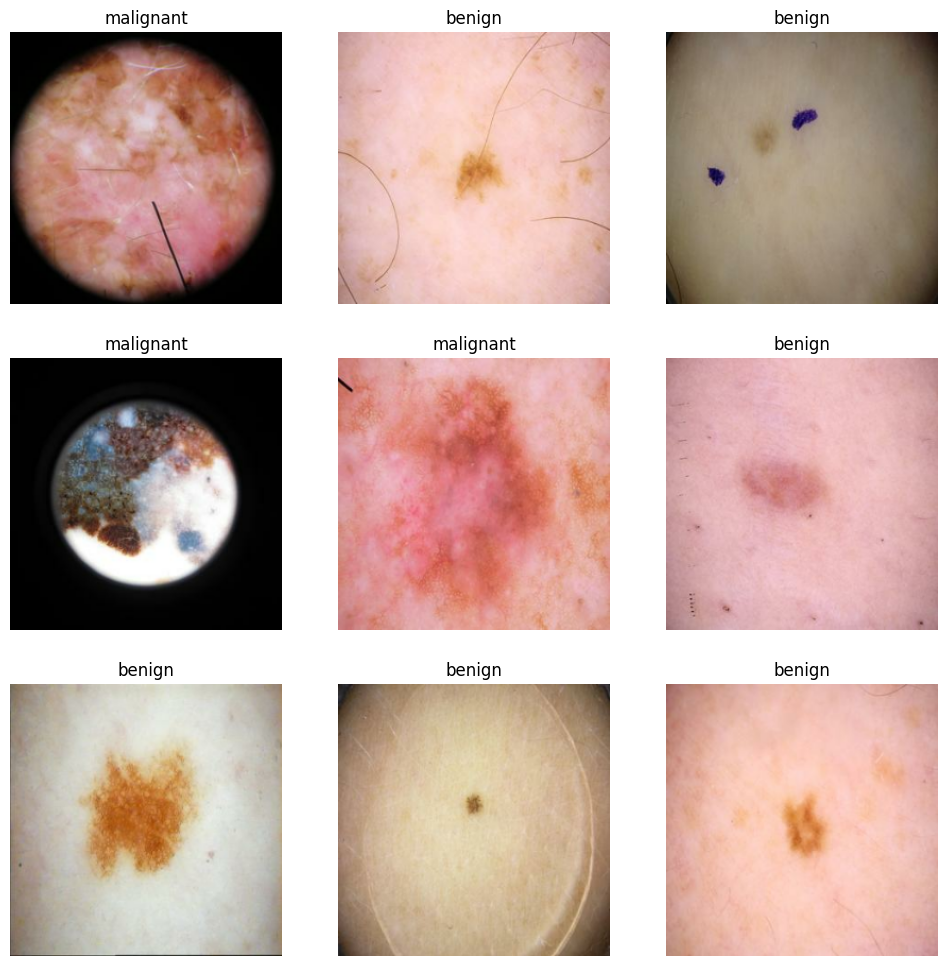

In [13]:
plt.figure(figsize=(12,12))
for image_batch, label_batch in train_data.take(2):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

## splitting dataset

In [14]:
def get_datset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle= True, shuffle_size=10000):
    ds_size= len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    train_size= int(train_split* ds_size)
    val_size=int(val_split * ds_size)
    train_ds = train_data.take(train_size)
    val_ds = train_data.skip(train_size).take(val_size)


    return train_ds, val_ds

In [15]:
train_ds, val_ds = get_datset_partitions_tf(train_data)

In [17]:
len(train_ds), len(val_ds)

(120, 15)

## Data Augmentation

In [18]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (IMAGE_SIZE, IMAGE_SIZE))),
    tf.keras.layers.Rescaling(1.0/255)
])

In [19]:
data_augmentation = tf.keras.Sequential([
   layers.RandomFlip("horizontal" or "vertical"),
   layers.RandomRotation(0.2),
   layers.RandomZoom(0.2),
   layers.RandomTranslation(height_factor=0.2, width_factor=0.2),  
#    layers.RandomContrast(factor=0.1),              # Adjusts contrast randomly by up to 10%
#    layers.RandomBrightness(factor=0.1) 
])

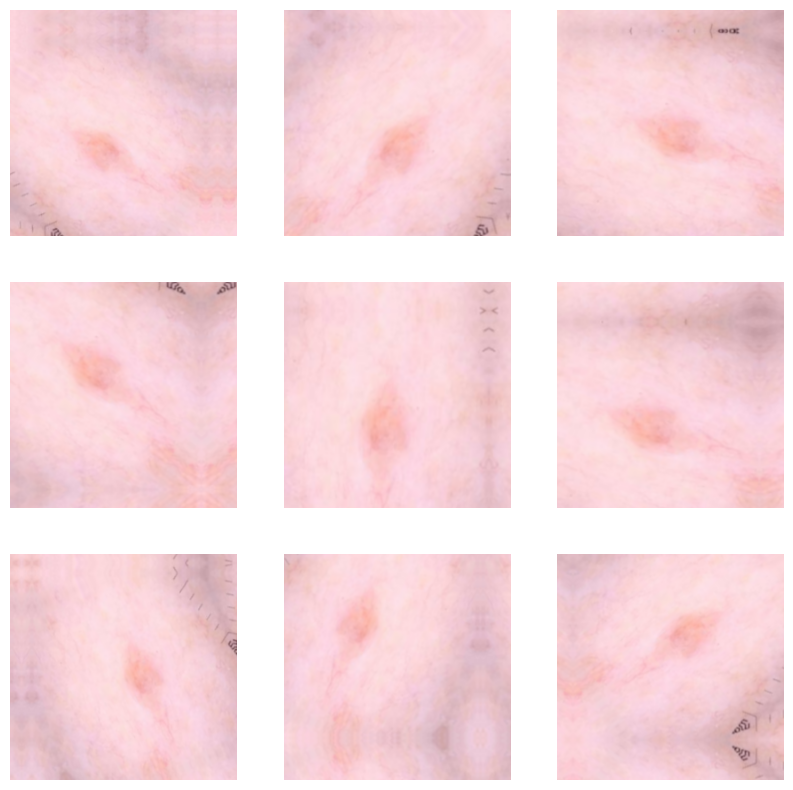

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(5):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## modelling

In [21]:
# from tensorflow.keras.applications import VGG16 
from tensorflow.keras.applications import EfficientNetB0
# Load pre-trained model 
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False  

# Add custom layers for fine-tuning
inputs = Input(shape=(256,256, 3))
x=resize_and_rescale(inputs)
x = data_augmentation(inputs)
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  
x = Dropout(0.5)(x)  
predictions = Dense(2, activation='sigmoid')(x)  

# Create the final fine-tuned model
model = Model(inputs=base_model.input, outputs=predictions)

In [22]:
from keras import optimizers
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5, beta_1=0.9, beta_2=0.999),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [23]:

checkpoint_path = "cancerseverity_model_checkpoint.weights.h5"
checkpoint_callback = ModelCheckpoint(
                            checkpoint_path,                             
                            save_weights_only=True,                      
                            monitor="val_loss",                       
                            save_best_only=True
                             )
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1,
                           mode='auto', restore_best_weights=True)

In [24]:
history = model.fit(
    train_ds,
    epochs=10,
    batch_size = BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    callbacks=[checkpoint_callback, early_stop]

)

Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 689s 5s/step - accuracy: 0.8155 - loss: 0.5217 - val_accuracy: 0.9323 - val_loss: 0.1946
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 691s 6s/step - accuracy: 0.9317 - loss: 0.1803 - val_accuracy: 0.9406 - val_loss: 0.1819
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 695s 6s/step - accuracy: 0.9391 - loss: 0.1536 - val_accuracy: 0.9458 - val_loss: 0.1590
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 677s 5s/step - accuracy: 0.9595 - loss: 0.1114 - val_accuracy: 0.9458 - val_loss: 0.1424
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 746s 6s/step - accuracy: 0.9628 - loss: 0.0917 - val_accuracy: 0.9417 - val_loss: 0.1843
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 704s 6s/step - accuracy: 0.9687 - loss: 0.0903 - val_accuracy: 0.9385 - val_loss: 0.1892
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 633s 5s/step - accuracy: 0.9705 - loss: 0.0842 - val_accuracy: 0.9542 - val_loss: 0.1462
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 597s 5s/step - accuracy: 0.9794 - loss: 0.0620 - val_accu

### Evaluation

In [25]:
import numpy as np
y_pred = []
y_true = []

for image_batch, label_batch in test_data:
    predictions = model.predict(image_batch)
    predicted_labels = np.argmax(predictions, axis=-1)
    y_pred.extend(predicted_labels)
    y_true.extend(label_batch.numpy())

2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 5s/step


In [26]:
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

class_names=["malignant", "benign"]
print(classification_report(y_true, y_pred, target_names=class_names))

Accuracy: 0.92
              precision    recall  f1-score   support

   malignant       0.90      0.94      0.92       500
      benign       0.94      0.90      0.92       500

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



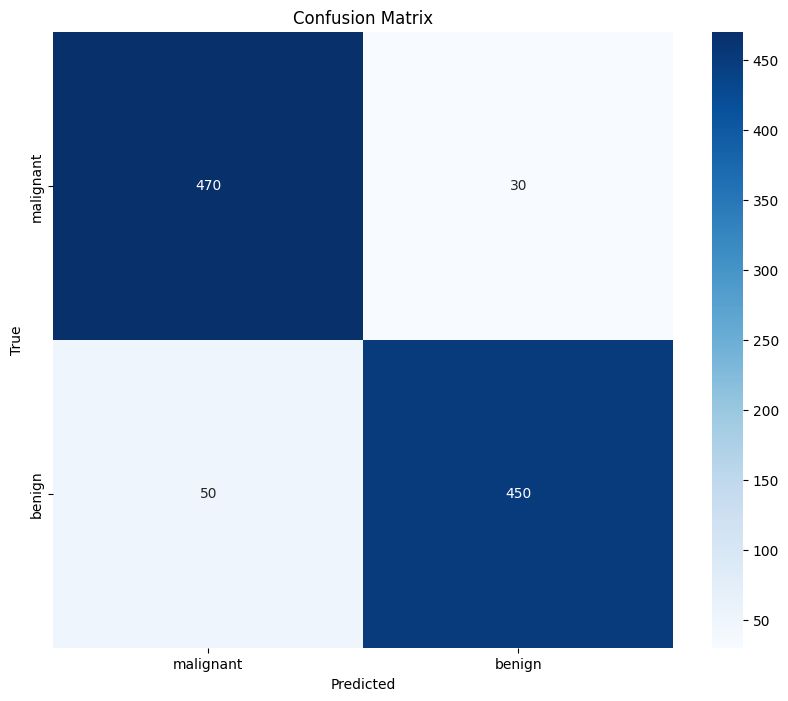

In [27]:
conf_matrix = confusion_matrix(y_true, y_pred)
target_names= class_names
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## save the model

In [28]:
model.save('severe_cancer_model1.keras')